<a href="https://colab.research.google.com/github/drivera27/Employee-Churn-Project/blob/main/EmployeeChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Churn Analytics Project

**To-do:**
* Prepare `df` for classification
  * Drop `employee_id`
* Perform quick EDA to determine which metrics to use
  * Are the classes (quit vs. non-quit) even?
* Use a RandomForest classifier
  * Import `scikit-learn` RF
* Add predictions and prediction scores to `df`
* Upload updated `df` to BigQuery

## Setup

### Importing libraries

In [1]:
# import libraries
from google.cloud import bigquery
from google.colab import auth

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Retrieving data via BigQuery

In [2]:
auth.authenticate_user()

# initialize client for bigquery
project_id = 'essential-cairn-479919-a3'
client = bigquery.Client(project=project_id, location='US')

# connect to BigQuery database
dataset_ref = client.dataset('EmployeeData', project=project_id)
dataset = client.get_dataset(dataset_ref)

In [21]:
# retrieve HR table from BigQuery
HR_ref = dataset.table(table_id='HRdata')
HR_table = client.get_table(HR_ref)

# convert to pandas DataFrame
df = client.list_rows(table=HR_table).to_dataframe()

# print first 5 rows and verify
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.38,0.53,2,157,3,0,1,0,sales,low,EMP00001
1,0.80,0.86,5,262,6,0,1,0,sales,medium,EMP00002
2,0.11,0.88,7,272,4,0,1,0,sales,medium,EMP00003
3,0.72,0.87,5,223,5,0,1,0,sales,low,EMP00004
4,0.37,0.52,2,159,3,0,1,0,sales,low,EMP00005


In [22]:
# retrieve new employees table from BigQuery
new_table_ref = dataset.table('NewEmployees')
new_table = client.get_table(new_table_ref)

# create dataframe for new employees table
df2 = client.list_rows(table=new_table).to_dataframe()

# print first 5 rows and verify
df2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.537849,0.122914,2,208,2,0,0,0,IT,high,NE15043
1,0.056211,0.322600,2,229,5,1,0,0,IT,low,NE15086
2,0.555186,0.555949,2,187,3,0,0,0,RandD,medium,NE15035
3,0.605273,0.713086,2,218,3,0,0,0,RandD,high,NE15069
4,0.043437,0.162372,2,175,3,0,0,0,RandD,high,NE15082


## EDA

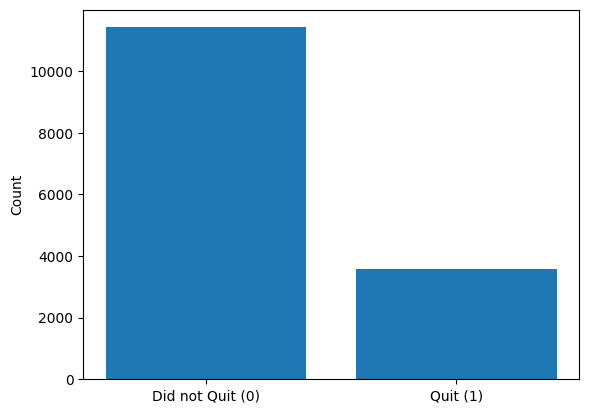

In [23]:
# display bar chart with quitting and non-quitting employees
quit_count = df['Quit_the_Company'].value_counts()

plt.bar(quit_count.index, quit_count.values,
        tick_label=['Did not Quit (0)', 'Quit (1)'])
plt.ylabel('Count')
plt.show();

As shown, there are far more employees who did not quit than those who did, which means our two classes are heavily imbalanced. Because of the imbalance, accuracy may not be the best metric to test our model's performance. Instead, it is best to use F1 score as our primary metric when evaluating our model. F1 score takes an average of two other metrics (precision and recall), and is better at handling imbalanced classes in datasets.

## Modeling

In [24]:
# create a function that will prepare data and create a pipeline
# could also make this a class instead ?
def churn_model(data):
  '''This function prepares the data for modeling, then uses
  scikit-learn's Random Forest model to predict employee churn.'''

  # drop irrelevant columns
  data = data.drop(columns=['employee_id'])

  # separate independent and dependent (target) features
  X = data.drop(columns=['Quit_the_Company'], axis=1)
  y = data['Quit_the_Company']

  # identify categorical and numerical columns
  categorical = ['Departments', 'salary']
  numerical = X.columns[:2].tolist()

  # transform categorical variables into numerical using one-hot encoding
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat',
           OneHotEncoder(handle_unknown='ignore'), categorical)
      ], remainder='passthrough')

  # create a preprocessor
  # using sklearn's RF model and our preprocessor
  model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', RandomForestClassifier(random_state=27))]) # random seed to reproduce results

  # split data for training and testing (80:20)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

  # train RF model
  model.fit(X_train, y_train)

  # predict using test set
  predictions = model.predict(X_test)

  # return classification report to evaluate predictions
  # using sklearn
  print(classification_report(y_test, predictions))

In [25]:
churn_model(data=df)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2286
         1.0       0.99      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [27]:
churn_model(data=df2)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Preparing data for modeling

In [6]:
# drop irrelevant columns (employee ID)
df = df.drop(columns=['employee_id'])

In [7]:
# separate independent and dependent (target) features
X = df.drop(columns=['Quit_the_Company'], axis=1)
y = df['Quit_the_Company']

In [8]:
# identify categorical and numerical features
categorical = ['Departments', 'salary']
numerical = X.columns[:-2].tolist()

# transform categorical variables to numerical using one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',
        OneHotEncoder(handle_unknown='ignore'), categorical)
        ], remainder='passthrough')

### RandomForest Model
* `stratify`?

In [ ]:
# create a pipeline using a RF model and our previous preprocessor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=27))
])

In [ ]:
# split data for training and testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

In [ ]:
# train RF model
model.fit(X_train, y_train)

# predict using test set
predictions = model.predict(X_test)

In [ ]:
# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2286
         1.0       0.99      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



# TO-DO:
* Add predictions back into df
* Write data into BigQuery

In [26]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.38,0.53,2,157,3,0,1,0,sales,low,EMP00001
1,0.80,0.86,5,262,6,0,1,0,sales,medium,EMP00002
2,0.11,0.88,7,272,4,0,1,0,sales,medium,EMP00003
3,0.72,0.87,5,223,5,0,1,0,sales,low,EMP00004
4,0.37,0.52,2,159,3,0,1,0,sales,low,EMP00005
...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low,EMP14995
14995,0.37,0.48,2,160,3,0,1,0,support,low,EMP14996
14996,0.37,0.53,2,143,3,0,1,0,support,low,EMP14997
14997,0.11,0.96,6,280,4,0,1,0,support,low,EMP14998


### Predict on `df2` (New Employees data)

In [ ]:
# drop irrelevant columns (employee ID) from df2
df2_processed = df2.drop(columns=['employee_id']).copy()

# Make predictions on df2
df2_predictions = model.predict(df2_processed)
df2_prediction_probs = model.predict_proba(df2_processed)

# Add predictions and prediction probabilities to df2
df2['predicted_quit'] = df2_predictions
df2['quit_probability'] = df2_prediction_probs[:, 1]

# Display the first few rows of df2 with predictions
display(df2.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id,predicted_quit,quit_probability
0,0.537849,0.122914,2,208,2,0,0,0,IT,high,NE15043,0.0,0.00
1,0.056211,0.322600,2,229,5,1,0,0,IT,low,NE15086,0.0,0.32
2,0.555186,0.555949,2,187,3,0,0,0,RandD,medium,NE15035,0.0,0.05
3,0.605273,0.713086,2,218,3,0,0,0,RandD,high,NE15069,0.0,0.00
4,0.043437,0.162372,2,175,3,0,0,0,RandD,high,NE15082,0.0,0.33
